In [2]:
import matplotlib.pyplot as plt
from skimage.color import rgb2gray 
from skimage.io import imread, imsave
from commons import plot
import numpy as np
from skimage.filters import gaussian
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
import cv2 as cv
from skimage.transform import resize
from glob import glob

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
#!pip install open3d 
#!pip install opencv-python

In [3]:
images_to_test = glob("depth_map_analyze/*")

In [41]:
color_raw = o3d.io.read_image(images_to_test[3])
depth_raw = o3d.io.read_image(images_to_test[3])

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw, 
    depth_raw,
    convert_rgb_to_intensity=True)

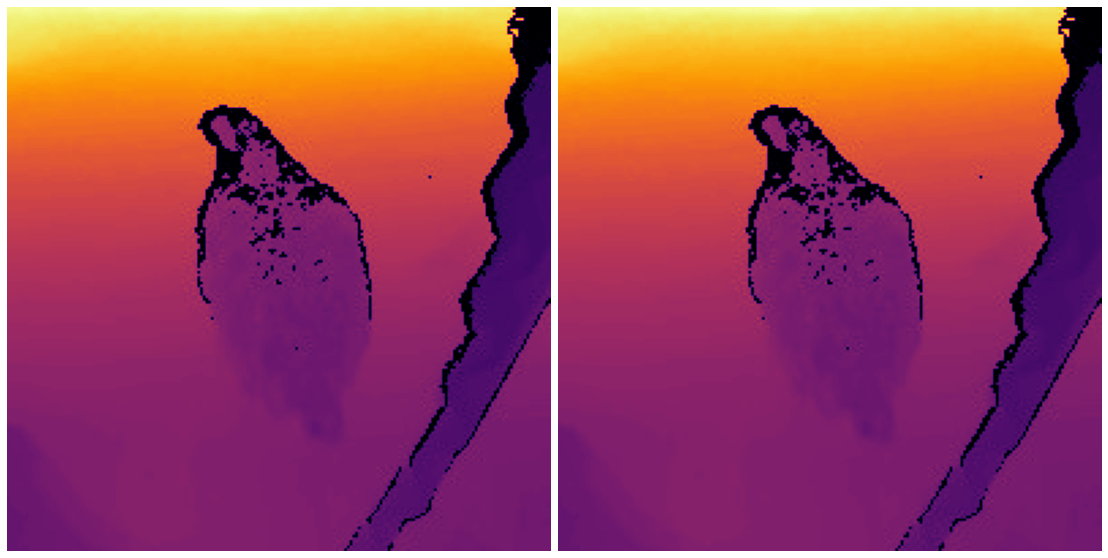

In [42]:
plot([rgbd_image.color, rgbd_image.depth], (1, 2))

In [43]:
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic(
    o3d.camera.PinholeCameraIntrinsicParameters.Kinect2DepthCameraDefault
)

In [44]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)

In [45]:
x, y, z = np.asarray(pcd.points).reshape(3, -1)

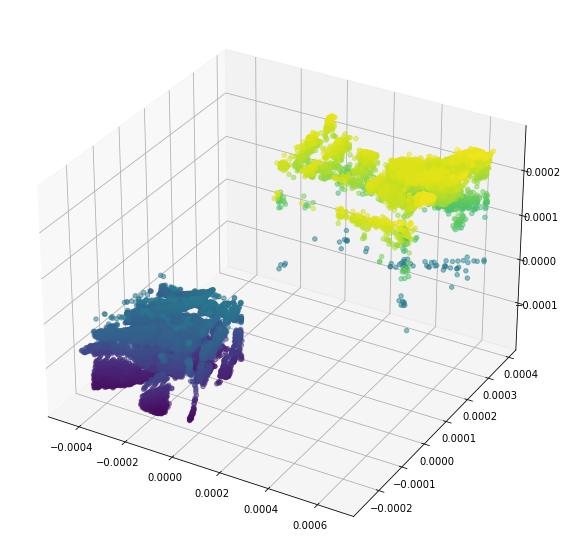

In [46]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=z, alpha=0.5)
plt.show()

In [47]:
pcd.paint_uniform_color([1, 0.706, 0])
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
o3d.visualization.draw_geometries([pcd])

In [25]:
_, inliers = pcd.segment_plane(distance_threshold=0.000009,
                               ransac_n=5,
                               num_iterations=500)

inlier_cloud = pcd.select_by_index(inliers)
inlier_cloud.paint_uniform_color([1.0, 0, 0])
outlier_cloud = pcd.select_by_index(inliers, invert=True)

In [26]:
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [ ]:
aabb = outlier_cloud.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)

obb = outlier_cloud.get_oriented_bounding_box()
obb.color = (0, 1, 0)

o3d.visualization.draw_geometries([outlier_cloud, aabb, obb])

In [ ]:
alpha = 0.01

tetra_mesh, pt_map = o3d.geometry.TetraMesh.create_from_point_cloud(outlier_cloud)
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(outlier_cloud, 
                                                                     alpha, 
                                                                     tetra_mesh,
                                                                     pt_map);
mesh.paint_uniform_color([0.4, 0.7, 0.5])
mesh.compute_triangle_normals()
o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud, mesh])